In [35]:
import sys
import os
import gc
import warnings
warnings.filterwarnings('ignore')
import random
import scipy as sp
import numpy as np
import pandas as pd
from glob import glob
from pathlib import Path
import joblib
import pickle
import itertools
from tqdm.auto import tqdm

import torch
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import xgboost as xgb
from catboost import Pool, CatBoostRegressor, CatBoostClassifier

In [36]:
METHOD_LIST = ['lightgbm', 'xgboost', 'catboost']
MODEL_DATA_PATH = Path("./model/")
OOF_DATA_PATH = Path("./oof/")
SUB_DATA_PATH = Path("./submit/")
VER = 1
seed = 42
n_folds = 3
target_col = 'money_room'
metric = 'RMSE'
metric_maximize_flag = False
num_boost_round = 2500
early_stopping_round = 200
verbose = 100
regression_lgb_params = {
    'objective': 'regression', # 'regression'
    'metric': 'rmse',
    'learning_rate': 0.05,
    'seed': seed,
}
regression_xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.05,
    'random_state': seed,
}

regression_cat_params = {
    'loss_function': 'RMSE',
    'learning_rate': 0.05,
    'iterations': num_boost_round,
    'random_seed': seed,
}
model_weight_dict = {'lightgbm': 0.50, 'xgboost': 0.10, 'catboost': 0.40}


In [37]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(seed)

In [38]:
train_df = pd.read_csv("./dataset/train.csv")
test_df = pd.read_csv('./dataset/test.csv').drop('index', axis=1)

In [39]:
train_df.head()

,target_ym,money_room,building_id,building_status,building_create_date,building_modify_date,building_type,building_name,building_name_ruby,homes_building_name,...,drugstore_distance,bank_distance,shopping_street_distance,est_other_name,est_other_distance,statuses,parking_keiyaku,money_hoshou_company,free_rent_duration,free_rent_gen_timing
0,202007,38000,a000002,1,2014-06-27 21:18:41,2024-05-25 00:45:07,3,Plaisirりんくう,NaN,プレジール りんくう,...,NaN,NaN,NaN,NaN,NaN,110702/210202/220101/220201/220301/230101/2308...,NaN,NaN,NaN,NaN
1,202107,103000,a000004,1,2017-02-05 20:43:26,2024-08-17 12:12:51,1,向原パークハイツ,NaN,向原パークハイツ,...,435.0,NaN,NaN,小竹向原駅,320.0,110301/210101/210201/210301/220101/220201/2203...,NaN,初回賃料等の50％、更新時1年毎に1万円,NaN,NaN
2,202101,50000,a000005,1,2014-06-27 20:32:50,2023-09-17 23:53:57,3,エナージ美香保,NaN,エナージ美香保,...,NaN,NaN,NaN,NaN,NaN,110201/110901/121001/210101/210202/220101/2202...,NaN,？月額家賃の50％、毎年10，000円 ？月額家賃の100％,NaN,NaN
3,202007,37000,a000008,1,2014-06-27 23:06:27,2024-03-08 00:10:05,3,エルディム希望,NaN,エルディム希望,...,NaN,NaN,NaN,生鮮食品オンリーワン 山手店,1114.0,121002/210202/210301/220101/220201/220301/2205...,NaN,契約時保証委託料：22，000円 月額保証委託料：賃料総額の2．2％又は5．5％,NaN,NaN
4,202101,33000,a000008,1,2014-06-27 23:06:27,2024-03-08 00:10:05,3,エルディム希望,NaN,エルディム希望,...,NaN,NaN,NaN,福山市立泉小学校,469.0,110301/121002/220201/220301/220501/230101/2302...,NaN,利用可（相談）,NaN,NaN


In [40]:
test_df.head()

,target_ym,building_id,building_status,building_create_date,building_modify_date,building_type,building_name,building_name_ruby,homes_building_name,homes_building_name_ruby,...,drugstore_distance,bank_distance,shopping_street_distance,est_other_name,est_other_distance,statuses,parking_keiyaku,money_hoshou_company,free_rent_duration,free_rent_gen_timing
0,202207,a372446,1,2014-06-27 20:30:14,2024-02-09 00:10:05,3,シャーメゾンエランA,NaN,シャーメゾンELAN A棟,シャーメゾンエラン Aトウ,...,NaN,NaN,NaN,NaN,NaN,110102/110903/121002/210301/220101/220201/2203...,1.0,【個人契約】 初回契約事務手数料：22，000円（税込）、月額保証料：賃料等の1％,NaN,NaN
1,202301,a276097,1,2014-06-28 02:47:45,2024-08-15 02:24:34,1,マルコフォート,NaN,マルコフォート,マルコフオート,...,120.0,NaN,NaN,NaN,NaN,210201/220501/230102/240104/290902/260101/2904...,NaN,NaN,NaN,NaN
2,202307,a290359,1,2014-06-27 21:18:44,2024-04-01 19:59:13,3,リバーサイドハウス松浪,NaN,リバーサイドハウス,リバーサイドハウス,...,1060.0,NaN,NaN,いこらも〜る泉佐野,862.0,110301/110902/121002/210101/210202/210301/2201...,NaN,初回保証委託料は総賃料の50％要,NaN,NaN
3,202207,a200797,1,2014-06-27 20:22:54,2023-04-03 00:10:05,3,サンリットA棟,NaN,サン リットA,NaN,...,NaN,NaN,NaN,NaN,NaN,121002/210101/210202/220101/220201/220301/2205...,NaN,NaN,NaN,NaN
4,202201,a333901,1,2014-06-27 23:48:22,2024-08-15 01:36:06,1,ライオンズマンション日本橋第2,NaN,ライオンズマンシヨン日本橋第二,NaN,...,260.0,NaN,NaN,NaN,NaN,121001/230103/230201/240104/290901/310101/3201...,NaN,初回保証委託料は月額収納合計金額(管理費・その他費用含)の50%、月額保証委託料は月額収納合...,NaN,NaN


In [41]:
print(train_df.shape)
print(test_df.shape)

(584507, 152)
(384540, 151)


In [42]:
submit_df = pd.read_csv('./dataset/sample_submit.csv', header=None)

In [43]:
submit_df.head()

,0,1
0,0,25310
1,1,70766
2,2,97844
3,3,84854
4,4,18753


In [44]:
numerical_features = []
categorical_features = []
for col in train_df.columns[2:]:
    if train_df[col].dtype==object:
        print(col)
    else:
        numerical_features.append(col)

building_id
building_create_date
building_modify_date
building_name
homes_building_name
homes_building_name_ruby
full_address
land_seigen
reform_exterior
reform_exterior_other
reform_common_area
building_tag_id
unit_name
reform_place
reform_place_other
reform_wet_area
reform_wet_area_other
reform_interior
reform_interior_other
reform_etc
renovation_date
renovation_etc
unit_tag_id
snapshot_create_date
new_date
snapshot_modify_date
timelimit_date
empty_contents
addr2_name
addr3_name
addr4_name
rosen_name1
eki_name1
bus_stop1
rosen_name2
eki_name2
bus_stop2
traffic_other
money_sonota_str1
money_sonota_str2
money_sonota_str3
parking_memo
school_ele_name
school_jun_name
est_other_name
statuses
money_hoshou_company


In [45]:
default_numerical_features = numerical_features
features = default_numerical_features

In [46]:
def Preprocessing(input_df: pd.DataFrame()) -> pd.DataFrame():
    output_df = input_df.copy()
    return output_df

In [47]:
train_df = Preprocessing(train_df)
test_df = Preprocessing(test_df)

In [48]:
def lightgbm_training(x_train: pd.DataFrame, y_train: pd.DataFrame, x_valid: pd.DataFrame, y_valid: pd.DataFrame):
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_valid = lgb.Dataset(x_valid, y_valid)

    model = lgb.train(
                params = regression_lgb_params,
                train_set = lgb_train,
                num_boost_round = num_boost_round,
                valid_sets = [lgb_train, lgb_valid],
                callbacks=[lgb.early_stopping(stopping_rounds=early_stopping_round, verbose=verbose),
                           lgb.log_evaluation(verbose),
                          ]
            )
    # Predict validation
    valid_pred = model.predict(x_valid)
    return model, valid_pred
def xgboost_training(x_train: pd.DataFrame, y_train: pd.DataFrame, x_valid: pd.DataFrame, y_valid: pd.DataFrame):
    xgb_train = xgb.DMatrix(data=x_train, label=y_train)
    xgb_valid = xgb.DMatrix(data=x_valid, label=y_valid)
    model = xgb.train(
                regression_xgb_params,
                dtrain = xgb_train,
                num_boost_round = num_boost_round,
                evals = [(xgb_train, 'train'), (xgb_valid, 'eval')],
                early_stopping_rounds = early_stopping_round,
                verbose_eval = verbose
            )
    # Predict validation
    valid_pred = model.predict(xgb.DMatrix(x_valid))
    return model, valid_pred
def catboost_training(x_train: pd.DataFrame, y_train: pd.DataFrame, x_valid: pd.DataFrame, y_valid: pd.DataFrame):
    cat_train = Pool(data=x_train, label=y_train)
    cat_valid = Pool(data=x_valid, label=y_valid)
    model = CatBoostRegressor(**regression_cat_params)
    model.fit(cat_train,
              eval_set = [cat_valid],
              early_stopping_rounds = early_stopping_round,
              verbose = verbose,
              use_best_model = True)
    # Predict validation
    valid_pred = model.predict(x_valid)
    return model, valid_pred

def gradient_boosting_model_cv_training(method: str, train_df: pd.DataFrame, features: list):
    # Create a numpy array to store out of folds predictions
    oof_predictions = np.zeros(len(train_df))
    oof_fold = np.zeros(len(train_df))
    kfold = KFold(n_splits=n_folds) # , shuffle=True, random_state=seed)
    for fold, (train_index, valid_index) in enumerate(kfold.split(train_df)):
        print('-'*50)
        print(f'{method} training fold {fold+1}')

        x_train = train_df[features].iloc[train_index]
        y_train = train_df[target_col].iloc[train_index]
        x_valid = train_df[features].iloc[valid_index]
        y_valid = train_df[target_col].iloc[valid_index]
        if method == 'lightgbm':
            model, valid_pred = lightgbm_training(x_train, y_train, x_valid, y_valid)
        if method == 'xgboost':
            model, valid_pred = xgboost_training(x_train, y_train, x_valid, y_valid)
        if method == 'catboost':
            model, valid_pred = catboost_training(x_train, y_train, x_valid, y_valid)

        # Save best model
        pickle.dump(model, open(MODEL_DATA_PATH / f'{method}_fold{fold + 1}_seed{seed}_ver{VER}.pkl', 'wb'))
        # Add to out of folds array
        oof_predictions[valid_index] = valid_pred
        oof_fold[valid_index] = fold + 1
        del x_train, x_valid, y_train, y_valid, model, valid_pred
        gc.collect()

    # Compute out of folds metric
    score = np.sqrt(mean_squared_error(train_df[target_col], oof_predictions))
    print(f'{method} our out of folds CV rmse is {score}')
    # Create a dataframe to store out of folds predictions
    oof_df = pd.DataFrame({target_col: train_df[target_col], f'{method}_prediction': oof_predictions, 'fold': oof_fold})
    oof_df.to_csv(OOF_DATA_PATH / f'oof_{method}_seed{seed}_ver{VER}.csv', index = False)

def Learning(input_df: pd.DataFrame, features: list):
    for method in METHOD_LIST:
        gradient_boosting_model_cv_training(method, input_df, features)

In [49]:
Learning(train_df, features)

--------------------------------------------------
lightgbm training fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11096
[LightGBM] [Info] Number of data points in the train set: 389671, number of used features: 98
[LightGBM] [Info] Start training from score 57674.328510
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 55866.8	valid_1's rmse: 16104.4
[200]	training's rmse: 46885	valid_1's rmse: 17256.9
Early stopping, best iteration is:
[75]	training's rmse: 59089.5	valid_1's rmse: 15856
--------------------------------------------------
lightgbm training fold 2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is 

In [50]:
def lightgbm_inference(x_test: pd.DataFrame):
    test_pred = np.zeros(len(x_test))
    for fold in range(n_folds):
        model = pickle.load(open(MODEL_DATA_PATH / f'lightgbm_fold{fold + 1}_seed{seed}_ver{VER}.pkl', 'rb'))
        # Predict
        pred = model.predict(x_test)
        test_pred += pred
    return test_pred / n_folds
def xgboost_inference(x_test: pd.DataFrame):
    test_pred = np.zeros(len(x_test))
    for fold in range(n_folds):
        model = pickle.load(open(MODEL_DATA_PATH / f'xgboost_fold{fold + 1}_seed{seed}_ver{VER}.pkl', 'rb'))
        # Predict
        pred = model.predict(xgb.DMatrix(x_test))
        test_pred += pred
    return test_pred / n_folds

def catboost_inference(x_test: pd.DataFrame):
    test_pred = np.zeros(len(x_test))
    for fold in range(n_folds):
        model = pickle.load(open(MODEL_DATA_PATH / f'catboost_fold{fold + 1}_seed{seed}_ver{VER}.pkl', 'rb'))
        # Predict
        pred = model.predict(x_test)
        test_pred += pred
    return test_pred / n_folds

def gradient_boosting_model_inference(method: str, test_df: pd.DataFrame, features: list):
    x_test = test_df[features]
    if method == 'lightgbm':
        test_pred = lightgbm_inference(x_test)
    if method == 'xgboost':
        test_pred = xgboost_inference(x_test)
    if method == 'catboost':
        test_pred = catboost_inference(x_test)
    return test_pred

def Predicting(input_df: pd.DataFrame, features: list):
    output_df = input_df.copy()
    output_df['pred'] = 0
    for method in METHOD_LIST:
        output_df[f'{method}_pred'] = gradient_boosting_model_inference(method, input_df, features)
        output_df['pred'] += model_weight_dict[method] * output_df[f'{method}_pred']
    return output_df

In [51]:
test_df = Predicting(test_df, features)

In [52]:
submit_df[1] = test_df['pred']

In [53]:
submit_df.to_csv(SUB_DATA_PATH / f'seed{seed}_ver{VER}_submission.csv', header=False, index=False)

In [55]:
model = pickle.load(open(MODEL_DATA_PATH / f"lightgbm_fold1_seed42_ver1.pkl", "rb"))
importance_df = pd.DataFrame(
    model.feature_importance(), index=features, columns=["importance"]
)
importance_df["importance"] = importance_df["importance"] / np.sum(
    importance_df["importance"]
)
importance_df.sort_values("importance", ascending=False)

,importance
house_area,0.127111
post1,0.100000
parking_money,0.096889
year_built,0.085333
money_kyoueki,0.052889
...,...
land_shidou_a,0.000000
land_shidou_b,0.000000
land_mochibun_b,0.000000
flg_new,0.000000


<Figure size 1000x800 with 0 Axes>

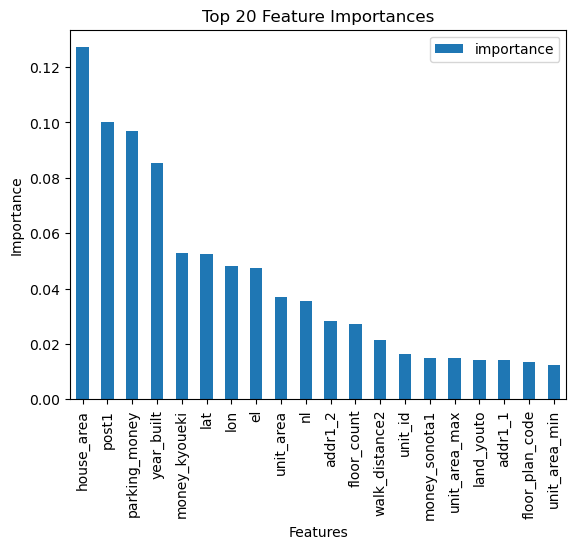

In [56]:
import matplotlib.pyplot as plt

# Plot feature importances
plt.figure(figsize=(10, 8))
importance_df.sort_values(by='importance', ascending=False).head(20).plot(kind='bar')
plt.title('Top 20 Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()